In [1]:
import os
os.chdir("../../")

In [2]:
import flax
from flax import linen as nn
from flax.core import unfreeze

import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import seaborn as sns
from datasets import regression_data
import tensorflow_probability.substrates.jax as tfp

from models.gaussian_mlp import gmlp 
from models.mlp import mlp 
from utilities.fits import fit
from utilities.gmm import gmm_mean_var
from utilities.predict import predict
from utilities import plot

In [3]:
X,y,x_test_1,y_test_1,x_test_2,y_test_2 = regression_data.data_set(n_points=100, poly=True,hetero=True)

In [11]:
X_sorted  = jnp.sort(X[:,0]).reshape(100,1)
Y_sorted  = jnp.sort(y)
x_stack =jnp.concatenate([x_test_1,X_sorted,x_test_2],axis=0)
y_stack = jnp.concatenate([y_test_1,y,y_test_2],axis=0)

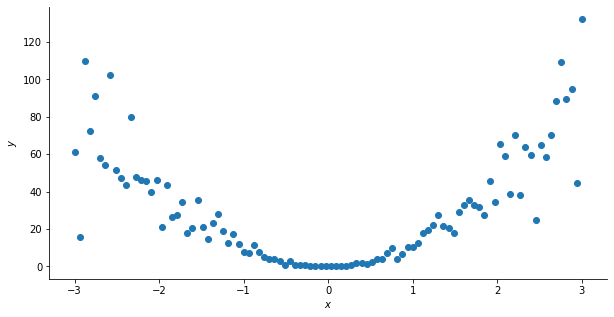

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(X,y)
plt.xlabel("$x$")
plt.ylabel("$y$")
sns.despine()
plt.show()

## MLP

In [13]:
mlp_model = mlp([32, 64, 32, 1],[nn.relu]*3,[0]*3)

In [14]:
mlp_params = mlp_model.init(jax.random.PRNGKey(0), X, True)

In [15]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [16]:
mlp_params, mlp_loss = fit(mlp_model, mlp_params, auxs, learning_rate= 0.001, epochs=1000, verbose=True)

Loss step 0:  906.39874
Loss step 100:  141.02464
Loss step 200:  128.30507
Loss step 300:  115.62603
Loss step 400:  101.336876
Loss step 500:  92.41577
Loss step 600:  89.60649
Loss step 700:  88.278175
Loss step 800:  87.765526
Loss step 900:  87.58423


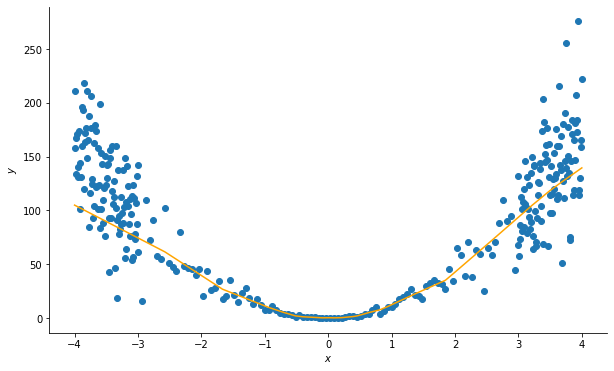

In [17]:
# x = jnp.linspace(-4, 4, 200).reshape(-1,1)
y_hat = mlp_model.apply(mlp_params, x_stack, True)
plt.figure(figsize=(10,6))
plt.scatter(x_stack, y_stack)
plt.plot(x_stack, y_hat, color="orange")
plt.xlabel("$x$")
plt.ylabel("$y$")
sns.despine()
plt.show()

Gaussian MLP

In [95]:
gmlp_model = gmlp(features=[128, 32], activations=[nn.relu]*2, dropout_rate=[0]*2)

In [96]:
# gmlp_model.tabulate(jax.random.PRNGKey(0), X, deterministic=True)

In [97]:
gmlp_params = gmlp_model.init(jax.random.PRNGKey(1), X, True)

In [98]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [99]:
gmlp_params, loss = fit(gmlp_model, gmlp_params, auxs, learning_rate=0.03, epochs=1000, verbose=True)

Loss step 0:  1848.1044
Loss step 100:  4.423924
Loss step 200:  4.2538924
Loss step 300:  3.8629894
Loss step 400:  3.2511952
Loss step 500:  3.086589
Loss step 600:  3.0233083
Loss step 700:  2.9745803
Loss step 800:  2.9305801
Loss step 900:  2.8902667


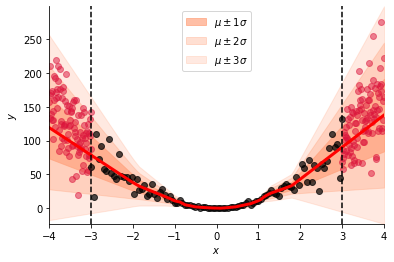

In [100]:
gmlp_mean, gmlp_sigma = gmlp_model.apply(gmlp_params, x_stack, True)
plot.plot_prediction(X, y, x_stack, y_stack, gmlp_mean, gmlp_sigma, "")

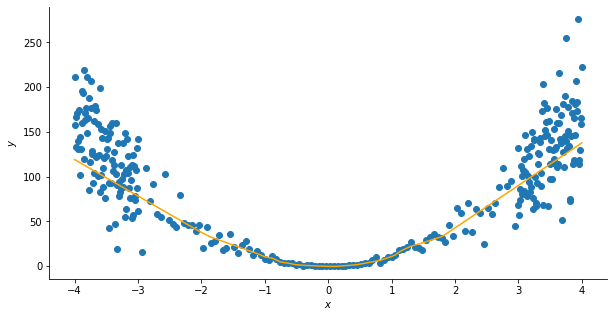

In [101]:
gmlp_mean, gmlp_sigma = gmlp_model.apply(gmlp_params, x_stack, True)
plt.figure(figsize=(10,5))
plt.scatter(x_stack, y_stack)
plt.plot(x_stack, gmlp_mean, color="orange")
plt.xlabel("$x$")
plt.ylabel("$y$")
sns.despine()
plt.show()


## MC Dropout Gaussian MLP

In [117]:
mc_model = gmlp(features=[32, 64, 32], activations=[nn.elu]*3, dropout_rate=[0.01]*3)

In [118]:
mc_params = mc_model.init(jax.random.PRNGKey(0), X, True)

In [119]:
mc_params, loss = fit(mc_model, mc_params, auxs, learning_rate=0.01, epochs=1000, verbose=True)

Loss step 0:  1783.3596
Loss step 100:  4.3637447
Loss step 200:  4.185346
Loss step 300:  4.123916
Loss step 400:  4.0672226
Loss step 500:  4.00454
Loss step 600:  3.9285214
Loss step 700:  3.8276184
Loss step 800:  3.7144432
Loss step 900:  3.6423595


In [120]:
n_stacks = 100
fn = lambda i : mc_model.apply(mc_params, x_stack, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)})
y_stacks = jax.vmap(fn, in_axes=(0))(jnp.arange(n_stacks))
mean_stacks = y_stacks[0]
sigma_stacks = y_stacks[1]

In [121]:
mc_mean, mc_sigma = gmm_mean_var(mean_stacks, sigma_stacks)

Text(0, 0.5, 'y')

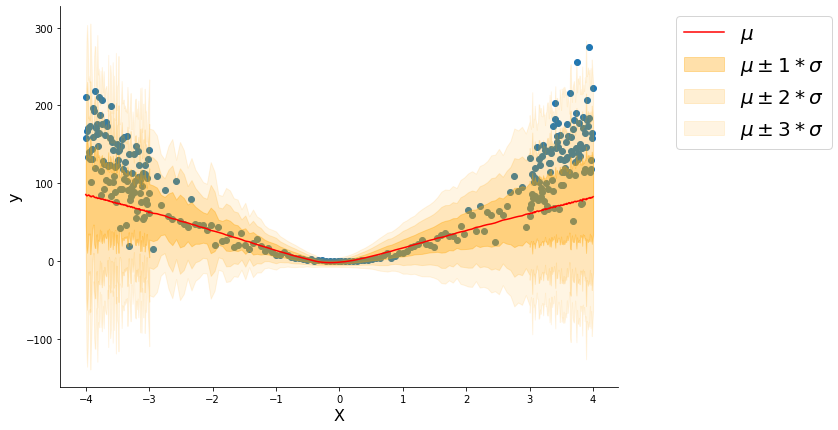

In [122]:
plt.figure(figsize=(10,7))
# plt.scatter(X, y, c="g")
# plt.scatter(x_test_1, y_test_1, c="b")
# plt.scatter(x_test_2, y_test_2, c="b")
plt.scatter(x_stack, y_stack)
plt.plot(x_stack, mc_mean, color="red", label = f"$ \mu $")

for i in range(1,4):
    plt.fill_between(x_stack.squeeze(), mc_mean - i*mc_sigma, mc_mean + i*mc_sigma, color="orange", alpha = 1/(i*3), label = f"$\mu \pm {i}*\sigma$")
plt.legend(bbox_to_anchor=(1.4,1), fontsize=20)
sns.despine()
plt.xlabel("X",fontsize=16)
plt.ylabel("y",fontsize=16)
# plt.xlim(-0.5, 1.0)
# plt.ylim(-3,3)
# plt.savefig("guassin_mlp_dropout1.pdf",bbox_inches="tight")

## Deep Ensemble Gaussian MLP

In [68]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [72]:
params_list = []
losses_list = []
n_models = 5

for i in range(5):
    params = gmlp_model.init(jax.random.PRNGKey(i), auxs['X'], deterministic = True)
    params, loss =  fit(gmlp_model, params, auxs, learning_rate=0.03, epochs=1000, verbose=False)
    params_list.append(params)
    losses_list.append(loss)


In [73]:
means_list,sigmas_list = predict(n_models, gmlp_model, params_list, x_stack)
de_mean, de_sigma = gmm_mean_var(means_list,sigmas_list)

Text(0, 0.5, 'y')

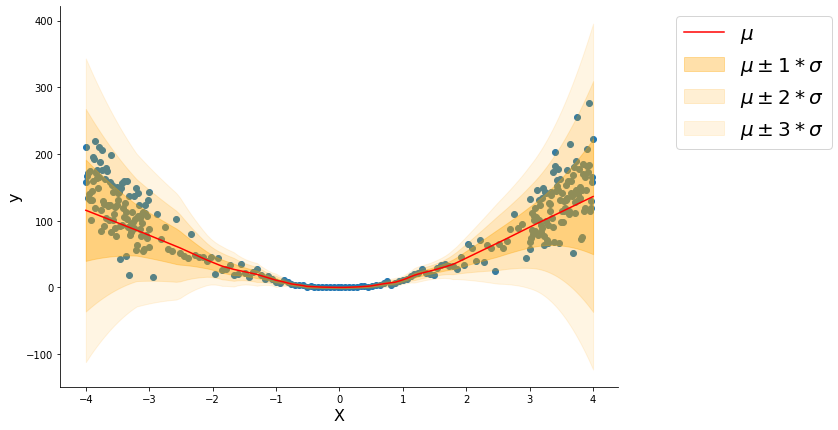

In [74]:
plt.figure(figsize=(10,7))
# plt.scatter(X, y, c="g")
# plt.scatter(x_test_1, y_test_1, c="b")
# plt.scatter(x_test_2, y_test_2, c="b")
plt.scatter(x_stack, y_stack)
plt.plot(x_stack, de_mean, color="red", label = f"$ \mu $")

for i in range(1,4):
    plt.fill_between(x_stack.squeeze(), de_mean - i*de_sigma, de_mean + i*de_sigma, color="orange", alpha = 1/(i*3), label = f"$\mu \pm {i}*\sigma$")
plt.legend(bbox_to_anchor=(1.4,1), fontsize=20)
sns.despine()
plt.xlabel("X",fontsize=16)
plt.ylabel("y",fontsize=16)
# plt.xlim(-0.5, 1.0)
# plt.ylim(-3,3)
# plt.savefig("guassin_mlp_dropout1.pdf",bbox_inches="tight")

In [124]:
def plot(ax, x, mean, sigma):
    # plt.figure(figsize=(10,7))
    ax.scatter(X, y, c="g")
    ax.scatter(x_test_1, y_test_1, c="b")
    ax.scatter(x_test_2, y_test_2, c="b")
    ax.plot(x, mean, color="red", label = f"$ \mu $")

    for i in range(1,4):
        ax.fill_between(x.squeeze(), mean - i*sigma, mean + i*sigma, color="orange", alpha = 1/(i*3), label = f"$\mu \pm {i}*\sigma$")
    ax.legend()
    sns.despine()
    ax.set_xlabel("X",fontsize=16)
    ax.set_ylabel("y",fontsize=16)

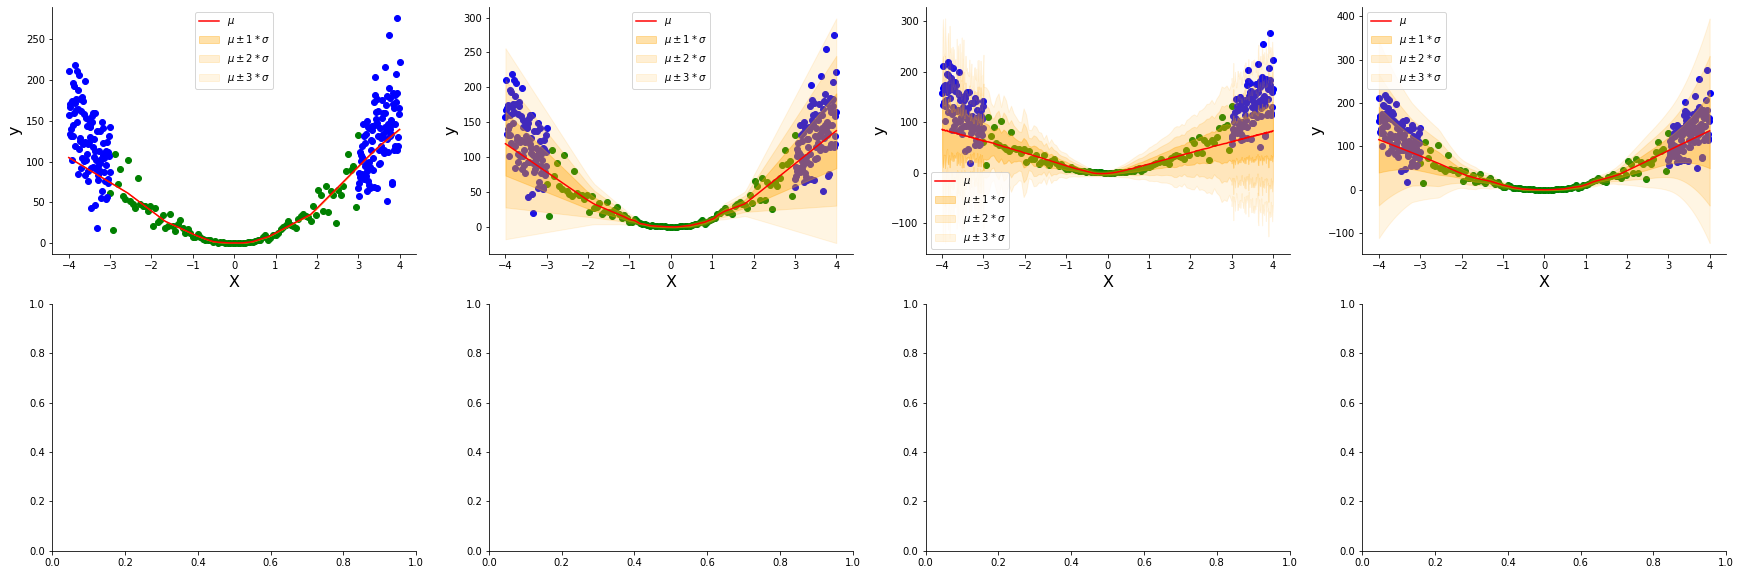

In [127]:
fig, ax = plt.subplots(2, 4, figsize=(30, 10))

plot(ax[0][0], x_stack, y_hat.squeeze(), jnp.array([0]*300))
plot(ax[0][1], x_stack, gmlp_mean, gmlp_sigma)
plot(ax[0][2], x_stack, mc_mean, mc_sigma)
plot(ax[0][3], x_stack, de_mean, de_sigma)